VERİ YÜKLEME VE HAZIRLAMA

In [3]:
import os
from pathlib import Path
import torch
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Klasör yolları
Label35_Path = Path(r"C:/Users/logotech/Downloads/5-aorta/5-aorta/labels")
Image35_Path = Path(r"C:/Users/logotech/Downloads/5-aorta/5-aorta/images")

# Dataset sınıfı
class AortaDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        """
        Dataset sınıfı, resimleri ve etiketleri yükler.
        image_dir: Görüntülerin bulunduğu klasör yolu
        label_dir: Etiketlerin bulunduğu klasör yolu
        transform: Resimlere ve etiketlere uygulanacak dönüşümler
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_paths = list(image_dir.glob("*.png"))  # resim dosyalarının listesi
        self.label_paths = [label_dir / (image_path.stem + ".png") for image_path in self.image_paths]  # etiket dosyalarının listesi
        self.transform = transform

    def __len__(self):
        """
        Veri setindeki öğe sayısını döndürür
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Verilen indeksteki resmi ve etiketini yükler.
        """
        image = Image.open(self.image_paths[idx]).convert('RGB')  # RGB formatında resim
        label = Image.open(self.label_paths[idx]).convert('L')  # Gri tonlamalı etiket

        # Eğer transform varsa uygula
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

# Görüntü ve etiketler için dönüşümler (transformations)
transform = transforms.Compose([
    transforms.Resize((640, 640)),  # Görüntü boyutlarını yeniden boyutlandırma
    transforms.ToTensor(),  # Görüntüyü tensöre dönüştürme
    transforms.Lambda(lambda x: x / 255.0)  # Piksel değerlerini 0-1 aralığına dönüştürme
])

# Dataset ve DataLoader oluşturma
dataset = AortaDataset(image_dir=Image35_Path, label_dir=Label35_Path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# İlk batch'i görüntüleme
for images, labels in dataloader:
    print(f"Image batch shape: {images.shape}")  # Resimlerin şekli (batch_size, kanal, yükseklik, genişlik)
    print(f"Label batch shape: {labels.shape}")  # Etiketlerin şekli (batch_size, kanal, yükseklik, genişlik)
    break  # İlk batch'i görmek için döngüden çıkıyoruz


Image batch shape: torch.Size([8, 3, 640, 640])
Label batch shape: torch.Size([8, 1, 640, 640])


Görüntü ve Maskeleri Yükleme ve Veri Setini Hazırlama

In [4]:
# Görüntüleri ve maskeleri yüklemek için fonksiyon
def load_images_and_masks(image_dir, mask_dir=None):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")])
    images = []
    masks = []

    for img_file in image_files:
        # Görüntüyü yükleme (grayscale olacak şekilde)
        img_path = os.path.join(image_dir, img_file)
        image = Image.open(img_path).convert("L")  # "L" parametresi grayscale (tek kanal) olarak dönüştürür
        image = np.array(image)

        images.append(image)

        # Maske yükleme (eğer maske varsa)
        if mask_dir:
            mask_path = os.path.join(mask_dir, os.path.splitext(img_file)[0] + '.png')
            mask = Image.open(mask_path)
            mask = np.array(mask)
            masks.append(mask)

    return images, masks if mask_dir else images

# ayak görüntüleri ve maskeleri yükleme
train_images, train_masks = load_images_and_masks(
    image_dir='C:/Users/logotech/Downloads/5-aorta/5-aorta/images',
    mask_dir='C:/Users/logotech/Downloads/5-aorta/5-aorta/labels'
)


# Görüntü ve maskeleri dönüştürme
transform = Compose([
  # Görüntüde kanalın öne alındığından emin oluyoruz
    ScaleIntensity(),  # Görüntüleri normalize ediyoruz
    EnsureType()  # Tensor tipine dönüştürüyoruz
])

train_images = [transform(torch.tensor(img).unsqueeze(0)) for img in train_images]  # Kanal boyutu için unsqueeze(0) ekliyoruz
train_masks = [transform(torch.tensor(mask).unsqueeze(0)) for mask in train_masks]

# DataLoader için verileri hazırlama
train_data = list(zip(train_images, train_masks))
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
 

Model, Kayıp Fonksiyonu ve Optimizer Ayarları

In [5]:
# Cihaz kontrolü (GPU varsa kullanılır)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# UNet Modeli
model = UNet(
    spatial_dims=2,  # 2D görüntüler üzerinde çalışıyoruz
    in_channels=1,  # Gri görüntü (tek kanal)
    out_channels=2,  # aort bölgesi ve arka plan
    channels=(16, 32, 64, 128, 256),  # UNet'teki katmanların genişlikleri
    strides=(2, 2, 2, 2),  # Katmanlar arasındaki sıçramalar
    num_res_units=2,  # Residual Unit sayısı
).to(device)

# Kayıp fonksiyonu ve optimizer
loss_function = nn.CrossEntropyLoss()  # Çok sınıflı sınıflandırma için uygun
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer, öğrenme oranı 0.0001

Eğitim Döngüsü ve Performans İzleme

In [6]:
# Kayıp ve doğruluk değerlerini kaydetmek için boş listeler
losses = []
accuracies = []

# Eğitim döngüsü
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_pixels = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        masks = masks.squeeze(1)
        masks = masks.long()

        outputs = model(images)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predicted_masks = outputs.argmax(dim=1)
        correct_predictions += (predicted_masks == masks).sum().item()
        total_pixels += masks.numel()

    # Epoch başına ortalama kayıp ve doğruluğu hesaplayın
    avg_loss = epoch_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_pixels

    # Listelere ekleyin
    losses.append(avg_loss)
    accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch 1/20, Loss: 0.7469, Accuracy: 0.5487
Epoch 2/20, Loss: 0.6350, Accuracy: 0.6434
Epoch 3/20, Loss: 0.5752, Accuracy: 0.7711
Epoch 4/20, Loss: 0.5243, Accuracy: 0.9227
Epoch 5/20, Loss: 0.4741, Accuracy: 0.9872
Epoch 6/20, Loss: 0.4255, Accuracy: 0.9944
Epoch 7/20, Loss: 0.3776, Accuracy: 0.9958
Epoch 8/20, Loss: 0.3318, Accuracy: 0.9967
Epoch 9/20, Loss: 0.2900, Accuracy: 0.9973
Epoch 10/20, Loss: 0.2540, Accuracy: 0.9978
Epoch 11/20, Loss: 0.2238, Accuracy: 0.9984
Epoch 12/20, Loss: 0.1982, Accuracy: 0.9988
Epoch 13/20, Loss: 0.1765, Accuracy: 0.9991
Epoch 14/20, Loss: 0.1579, Accuracy: 0.9992
Epoch 15/20, Loss: 0.1418, Accuracy: 0.9994
Epoch 16/20, Loss: 0.1279, Accuracy: 0.9995
Epoch 17/20, Loss: 0.1158, Accuracy: 0.9994
Epoch 18/20, Loss: 0.1051, Accuracy: 0.9995
Epoch 19/20, Loss: 0.0956, Accuracy: 0.9995
Epoch 20/20, Loss: 0.0873, Accuracy: 0.9995


Eğitim Sonuçlarını Grafiğe Döktük

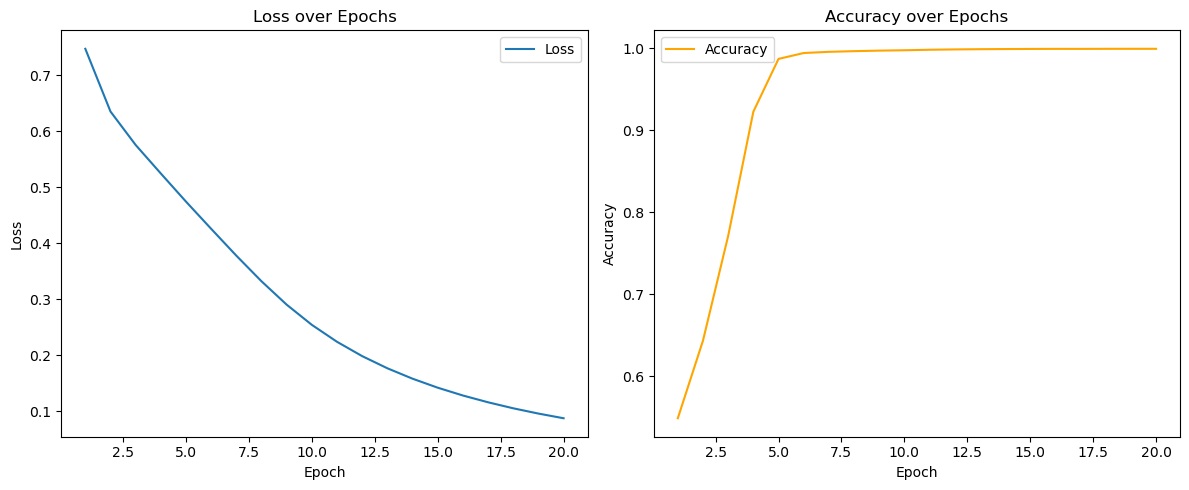

In [7]:
### import matplotlib.pyplot as plt

# Epoch başına kayıp grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Epoch başına doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracies, label="Accuracy", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show() 

Test Verisi Yükleme

In [8]:
import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms

# Test dizinindeki görüntüleri manuel olarak yükleyelim
def load_test_images(image_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
    images = []

    # Her görüntüyü yükleyip listeye ekleyelim
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        image = Image.open(img_path).convert('L')  # Siyah-beyaz (gri ölçekli) görüntü olarak yükleyelim
        images.append(image)

    return images

# Test görüntülerini yükleyelim
test_images = load_test_images('C:/Users/logotech/Downloads/5-aorta/5-aorta/images')

# Toplam test görüntü sayısını kontrol edelim
print(f"Toplam Test Görüntü Sayısı: {len(test_images)}")  # Yüklü görüntü sayısını kontrol edelim

# Görüntü dönüşümü (test seti için)
transform = transforms.ToTensor()

# Test görüntülerini tensöre dönüştürme
test_images_tensor = [transform(img) for img in test_images]

# DataLoader ile test verisini yükleme
test_loader = DataLoader(test_images_tensor, batch_size=1, shuffle=False)

# Test Loader'da kaç batch olduğunu kontrol edelim
print(f"Test Loader'daki batch sayısı: {len(test_loader)}")


Toplam Test Görüntü Sayısı: 350
Test Loader'daki batch sayısı: 350


Test Verisi Üzerinde Model Değerlendirmesi ve Görselleştirme


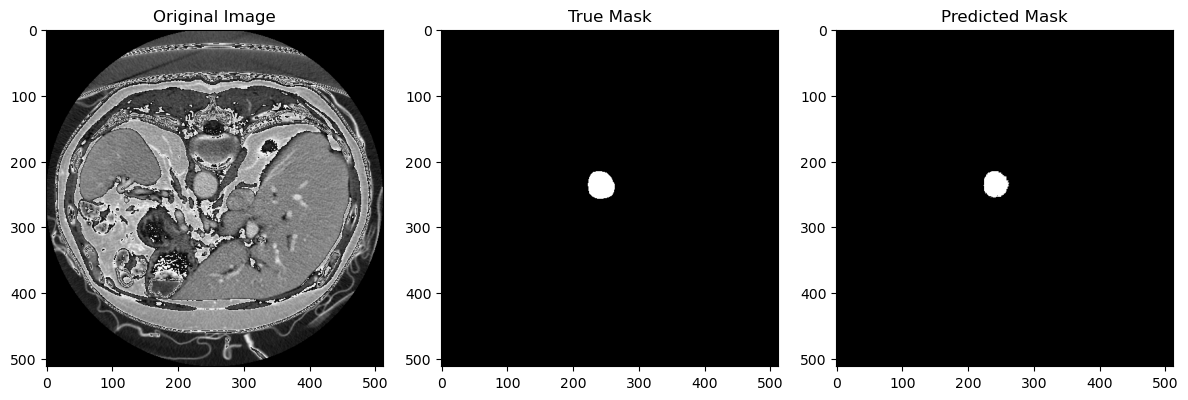

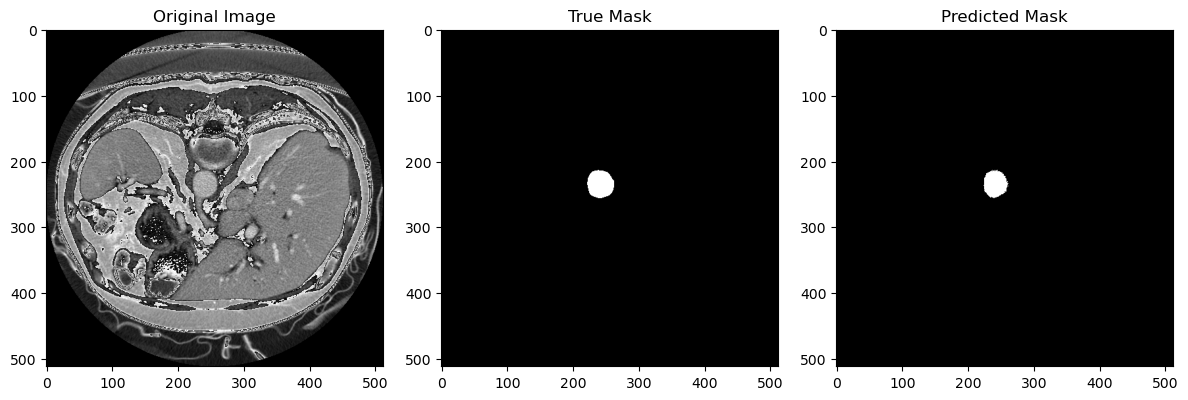

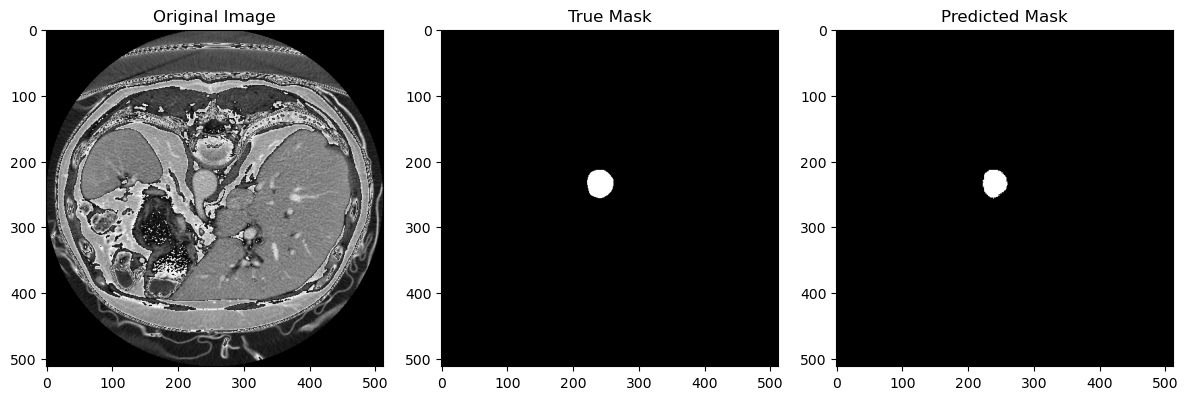

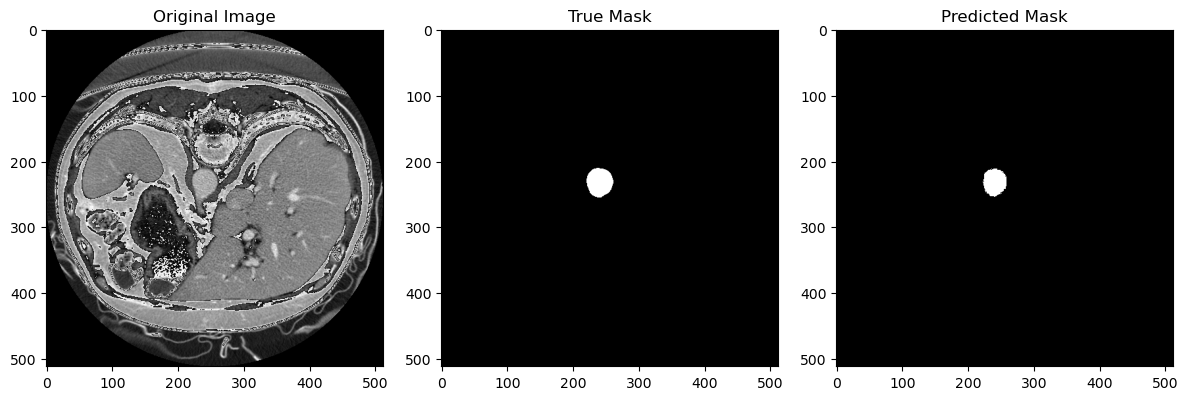

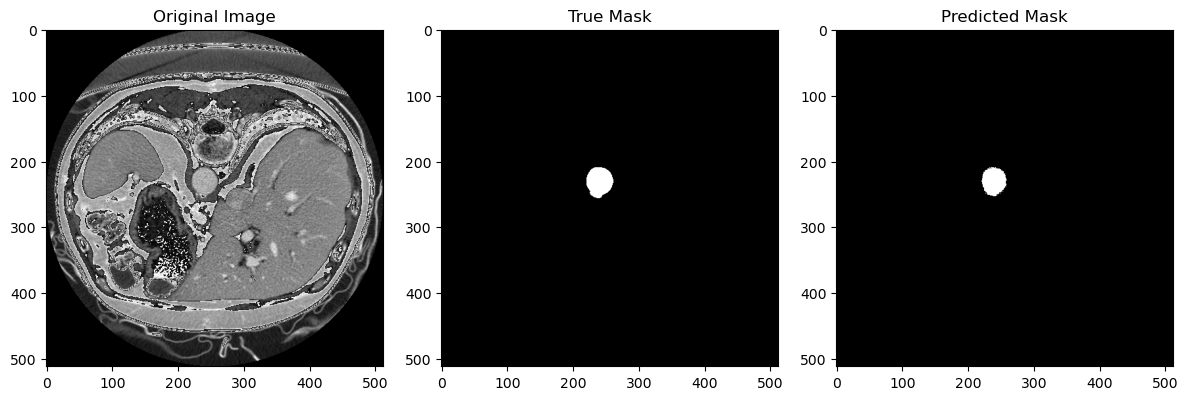

In [9]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# Test dizinindeki görüntüleri ve maskeleri manuel olarak yükleme fonksiyonu
def load_test_data(image_dir, mask_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Görüntüleri ve maskeleri gri tonlamaya çevirerek yükleme
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        images.append(np.array(image))
        masks.append(np.array(mask))

    return images, masks

# Test görüntüleri ve maskelerini yükleyelim
test_image_dir = 'C:/Users/logotech/Downloads/5-aorta/5-aorta/images'
test_mask_dir = 'C:/Users/logotech/Downloads/5-aorta/5-aorta/labels'
test_images, test_masks = load_test_data(test_image_dir, test_mask_dir)

# Dönüştürme işlemi: Tensöre çevirme
transform = transforms.ToTensor()

# Test görüntülerini tensöre dönüştürme
test_images_tensor = [transform(img) for img in test_images]

# DataLoader ile test verisini yükleme
test_tensor_dataset = TensorDataset(torch.stack(test_images_tensor))
test_loader = DataLoader(test_tensor_dataset, batch_size=1, shuffle=False)

# Tahmin edilen maskeleri ve orijinal görüntüleri görselleştir
def visualize_predictions(image, predicted_mask, label_mask, output_path):
    plt.figure(figsize=(12, 4))

    # Orijinal görüntü
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.title("Original Image")

    # Gerçek maske (label)
    plt.subplot(1, 3, 2)
    plt.imshow(label_mask, cmap='gray')
    plt.title("True Mask")

    # Tahmin edilen maske
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.tight_layout()
    plt.show()  # Görselleştirmeyi doğrudan ekranda gösteriyoruz

# Modeli değerlendirme moduna geçiriyoruz
model.eval()

# Test verisindeki görüntüler için tahmin ve görselleştirme işlemi
with torch.no_grad():
    for i, (test_image_batch,) in enumerate(test_loader):
        # Test görüntüsünü cihaza taşıyıp modelden geçirin
        test_image_batch = test_image_batch.to(device)
        outputs = model(test_image_batch)
        predicted_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu()  # Tahmin edilen maske

        # Görselleştirme: Orijinal test görüntüsü, gerçek maske ve tahmin edilen maske
        original_image = test_image_batch.squeeze(0).cpu()  # Orijinal test görüntüsünü elde ediyoruz
        label_mask = torch.tensor(test_masks[i])  # Gerçek maske
        visualize_predictions(original_image, predicted_mask, label_mask, f'test_image_{i}_visual.png')

        # Sadece ilk birkaç örneği görselleştirmek için sınır koyalım
        if i == 4:
            break

Model Kaydetme

In [10]:
model_save_path = r'C:\Users\logotech\Documents\model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model başarıyla kaydedildi: {model_save_path}")


Model başarıyla kaydedildi: C:\Users\logotech\Documents\model.pth


Model Performansı Değerlendirme: En İyi ve En Kötü Tahminler


En iyi tahmin sonucu:
En iyi tahmin IoU değeri: 0.9478935698447893


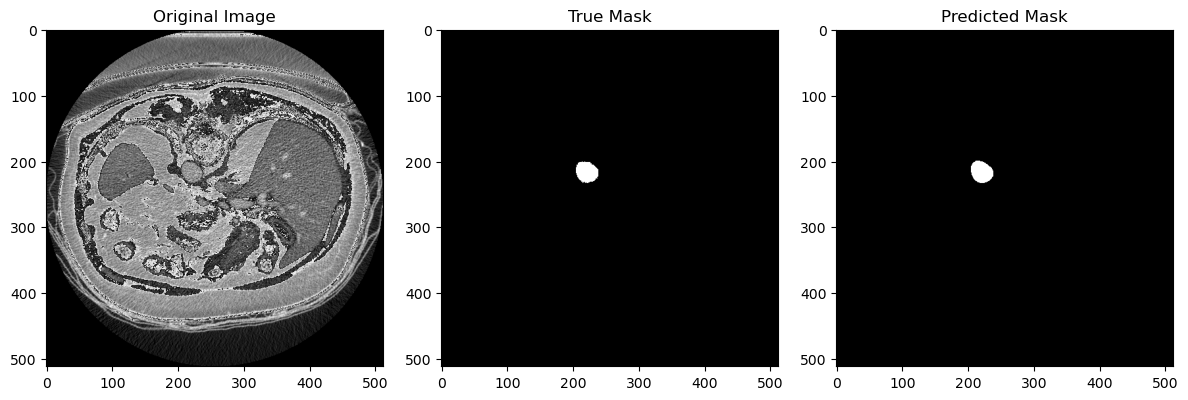

En kötü tahmin sonucu:
En kötü tahmin IoU değeri: 0.5942408376963351


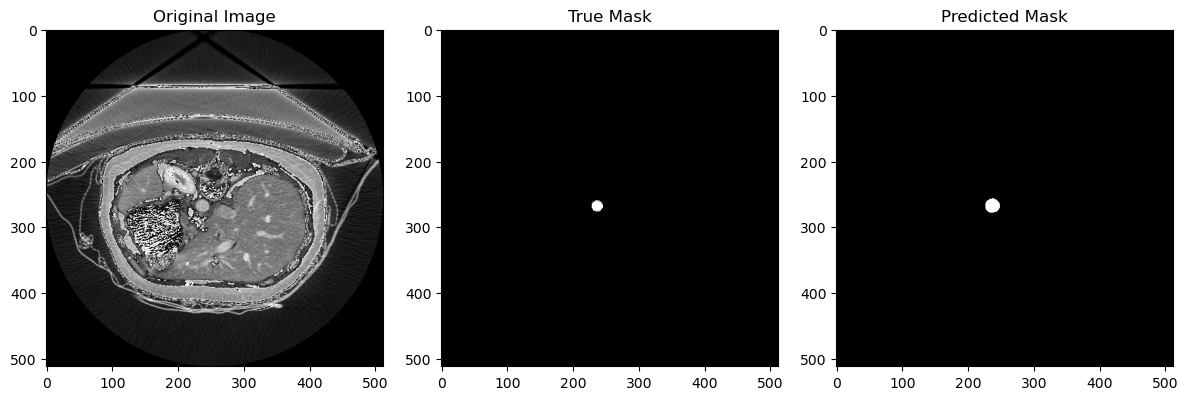

In [11]:
# IoU (Intersection over Union) hesaplama fonksiyonu
def calculate_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask)
    union = np.logical_or(pred_mask, true_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Test setindeki en iyi ve en kötü tahminleri bulma ve görselleştirme fonksiyonu
def find_best_and_worst_predictions(model, test_loader, true_masks, device):
    ious = []
    predictions = []
    original_images = []
    true_masks_array = []

    # Modeli değerlendirme moduna al
    model.eval()

    with torch.no_grad():
        for i, (test_image_batch,) in enumerate(test_loader):
            # Görüntüyü ve ilgili maskeyi cihaza yükle
            test_image_batch = test_image_batch.to(device)
            outputs = model(test_image_batch)
            predicted_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()  # Tahmin edilen maske

            # IoU'yu hesapla
            true_mask = true_masks[i]
            iou = calculate_iou(predicted_mask, true_mask)
            ious.append(iou)

            # Orijinal görüntüleri ve tahminleri sakla
            original_images.append(test_image_batch.squeeze(0).cpu().numpy())
            predictions.append(predicted_mask)
            true_masks_array.append(true_mask)

    # En iyi ve en kötü tahminlerin sıralanması
    ious = np.array(ious)
    best_idx = np.argmax(ious)  # En yüksek IoU değerine sahip tahmin
    worst_idx = np.argmin(ious)  # En düşük IoU değerine sahip tahmin

    # En iyi tahmini görselleştir
    print("En iyi tahmin sonucu:")
    print(f"En iyi tahmin IoU değeri: {ious[best_idx]}")
    visualize_predictions(original_images[best_idx], true_masks_array[best_idx], predictions[best_idx], f'best_prediction.png')


    # En kötü tahmini görselleştir
    print("En kötü tahmin sonucu:")
    print(f"En kötü tahmin IoU değeri: {ious[worst_idx]}")
    visualize_predictions(original_images[worst_idx], true_masks_array[worst_idx], predictions[worst_idx], f'worst_prediction.png')


# Test setindeki en iyi ve en kötü tahminleri bul ve görselleştir
find_best_and_worst_predictions(model, test_loader, test_masks, device)